# Darcy-Weisbach Equation
The Darcy-Weisbach equation relates the head or pressure loss, resulting from friction along a length of conduit, to the average velocity of an incompressible fluid flow.  This equation is typically not suitable for gas flow.

## Head Loss Form
$$h_f = f_D \cdot \frac{L}{D_h} \cdot \frac{V^2}{2g}$$
where;

* $h_f$ is the head loss due to friction (SI units: m); Note: This is also proportional to the piezometric head along the pipe;
* $L$ is the length of the pipe (m);
* $D_h$ is the hydraulic diameter of the pipe (for a pipe of circular section, this equals the internal diameter of the pipe) (m);
* $V$ is the average flow velocity, experimentally measured as the volumetric flow rate per unit cross-sectional wetted area (m/s);
* $g$ is the local acceleration due to gravity $(m/s^2)$;
* $f_D$ is a dimensionless parameter called the Darcy friction factor, resistance coefficient, or simply friction factor.[3]

The Darcy friction factor $(f_D)$ can be found from a Moody diagram or it can be calculated (see below).

## Pressure Loss Form
$$\Delta p = \rho \cdot g \cdot h_f$$
where the pressure loss due to friction $Δp$ (Pa) is a function of:

* the ratio of the length to diameter of the pipe, $L / D$;
* the density of the fluid, $ρ$ (kg/m3);
* the mean flow velocity, $V$ (m/s), as defined above;
* Darcy Friction Factor, $f_D$, as defined above;

# Calculation of Friction Factor $(f_D)$

Calculation method for the friction factor depends on the flow regime as defined by the Reynolds number $(R_e)$

\begin{align}
    \mathrm{Re} &= \frac{\rho}{\mu} V D = \frac{VD}{\nu} \\
    \nu &= \frac{\mu}{\rho}
\end{align}

where;
* $\mu$ is the dynamic viscosity, implies a linear relationshipe between distance from fluid velocity at the wall $(u)$ and distance from the wall $(y)$: $\mu = \frac{\partial u}{\partial y}$.  Dynamic viscosity has units of pascal-seconds (Pa-s) or centipoise (cP).
* $\nu$ is the kinematic viscosity, which has units of $m^2/s$ or stokes 

## Flow Regimes

For this analysis, I will segregate the flow regimes as follows:

* $R_e < 2,000 \implies$ Laminar regime
* $2,000 < R_e \implies$ Turbulent regime

Note: for $2,000 < R_e < 3,000 $ is typically referred to as a Critical regime, which is not defined  with this approach.

## Formulas

### Laminar Flow
Equation for flow in the laminar regime (as defined above) as defined by Poiseuille's law for laminar flow is:
$$f_D = \frac{64}{R_e}$$

### Turbulent Flow
Equation for flow in the turbulent regime (as defined above) as defined by the Coleboork-White equation is:
$$\frac{1}{\sqrt{f_D}} = -2.00 \log_{10}\left(\frac{\epsilon}{3.7D_h} + \frac{2.51}{\mathrm{Re}\sqrt{f_D}}\right)$$

### Discontinuity
The resulting sets of equations result in a discontinuity at the laminar-turbulent flow transition.  To implement a continuous function, a modification will need to be made.

# Calculations

load and defined needed packages

In [1]:
import numpy as np
from pint import UnitRegistry
import math
ureg = UnitRegistry()
np.set_printoptions(precision=4)

## Check Units

calculation of Reynolds number

In [2]:
rho = 1000 * ureg.kilogram / ureg.meter**3# kg/m3
v = 4.0 *ureg.meter / ureg.sec# m/sec
mu = 8.90 * 10**-4 * ureg.pascal * ureg.sec# Pa-s, N-s/m2
d = 0.2 * ureg.meter

Re = rho * v * d / mu
print(Re.dimensionality) # check dimension
print(Re.magnitude)

dimensionless
898876.404494


## Function for the Evaluation of the Darcy-Weisbach Friction Factor

In [3]:
def f_cw(Re, d, epsilon):
    """
    Function to obtain the Darcy-Weisbach friction factor:
        Laminar Flow (Re <= 2000) -> Poiseuille's relationship
        Turbulent Flow (Re > 2000) -> evaluate the colebrrok-white equation 

    Input:
    -------------------------------------------------
    Re (required): reynolds number (dimensionless)
    d  (required): hydraulic diameter (length)
    epsilon (required): conduit roughness (length)
    
    Output:
    -------------------------------------------------
    f: darcy-weisbach friction factor (dimensionless)
    """


    if Re <= 2000.:
        f = Re / 64.
    else:
        sqrt_f = 10.0
        loop_max = 20
        inc = 1
        res = 10.0

        while res > 10**-8 and inc < loop_max:
            LHS = -2.0 * np.log10(epsilon / (3.7 * d) + 2.51 / (Re * sqrt_f))
            res = (LHS - 1./sqrt_f)**2 #squared error
            sqrt_f = 1./LHS
            inc = inc + 1
        f = sqrt_f**2

        if inc == loop_max:
            outText = "Friction Factor Did NOT Converge! Printed Value Should ~= 1.0"
            print(outText)
            print(-2.0 * np.log10(epsilon / (3.7 * d) + 2.51 / (Re * f**0.5)) * f**0.5)
    f_out = f
    return f_out

## Example

Calculate the head loss from friction over a range of flow rates

In [4]:
rho = 1200 # kg/m3
v = np.linspace(0., 0.1, 100) # m/sec
mu = 8.90 * 10**-4 # Pa-s, N-s/m2
d = 0.2 # m
epsilon = 0.005 # roughness
l = 1000. # conduit lenth (m)
g = 9.81 #m/s2

fric_fact = np.zeros(len(v))

for i in xrange(len(v)):
    Re = rho * v[i] * d / mu
    fric_fact[i]= f_cw(Re, d, epsilon)
    
h_f = fric_fact*(l/d)*(v**2/2*g)
dp = rho * g * h_f

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

## Results in Discontinuity at Laminar-Turbulent Transition (Re=2000)

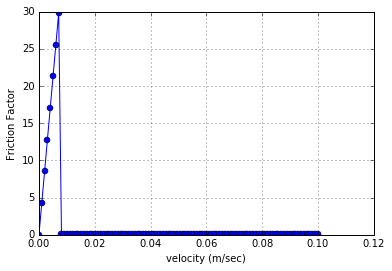

In [6]:
plt.plot(v,fric_fact,'o-')
plt.xlabel('velocity (m/sec)')
plt.ylabel('Friction Factor')
plt.grid()

Because this function is discontinuous at the transition between laminar and turbulent flow, an approximation to this will be made that includes a smooth transition.  This will allow for stable numerical implementation.

### General Purpose Friction Calculator

Using python JIT compiler (compiles into C)

In [7]:
q0 = 0.2*3600 # SS flow rate (m3/hr)
mu = 1.60 * 10**-3 # Dynamic viscosity (Pa-s, N-s/m2)
sg = 1.0 # specific gravity
rough = 0.9 # roughness (mm)
d = 273.1 # mm
SI = 1. # units are in SI

In [8]:
from numba import jit

In [9]:
@jit
def CheckUnits(flowRate, dynVisc, spGrav, ID, roughness, units = 0):
    """
    Calculations will all be performed in SI units; therefore, this method converts all units to consistent SI units 
    
    All calculations will be performed in consistent SI units.  
        Therefore, if units are input in US terms (units=0), they will be converted to SI for calculation.

        Units for Input (must maintain a constant system of units):

        INPUT:
                  |   DESCRIPTION      | US     | SI   |
        units     |system of units     | =0     | !=0  |
        ------------------------------------------------
        flowRate  |volumetric flow rate|gal/min |m3/hr |
        dynVisc   |dynamic viscosity   |cP      |Pa-s  |
        spGrav    |specific gravity    |none    |none  |
        ID        |internal diameter   |inch    |m     |
        roughness |pipe roughness      |inch    |m     |
        
        OUTPUT:          
        units     | SI   |symbol
        ------------------------------------------------
        density   |kg/m3 |rho
        flowRate  |m3/sec|Q
        ID        |m     |ID
        area      |m2    |area
        velocity  |m/sec |v
        dynVisc   |Pa-s  |mu
        roughness |m     |roughness
    """
    rho = spGrav * 1000 #kg/m3
    if units == 0:
        #convert from US to SI units
        Q = flowRate *3.7853/1000. / 60. # m3/sec
        ID = ID * 2.54 / 100. # m
        area = np.pi * ID **2 / 4.# m2
        v = Q / area # m/sec
        mu = dynVisc * 10**-3 # Pa-s
        roughness = roughness * 2.54 / 100. # m
    else:
        #convert to consistent SI units
        Q = flowRate / 3600. # m3/sec
        ID = ID / 1000. # m
        area = np.pi * ID **2 / 4.# m2
        v = Q / area # m/sec
        mu = dynVisc
        roughness = roughness / 1000. #m
    return rho, Q, ID, area, v, mu, roughness

@jit
def FrictionFact_jit(flowRate, dynVisc, spGrav, ID, roughness, units = 0):
    """
        All calculations will be performed in consistent SI units.  
        Therefore, if units are input in US terms (units=0), they will be converted to SI for calculation.

        Units for Input (must maintain a constant system of units):

                  |   DESCRIPTION      | SI   |
        units     |system of units     | !=0  |
        ------------------------------------------------
        flowRate  |volumetric flow rate|m3/sec|
        dynVisc   |dynamic viscosity   |Pa-s  |
        spGrav    |specific gravity    |none  |
        ID        |internal diameter   |m     |
        roughness |pipe roughness      |m     |

        Output:
        -------------------------------------------------
        f: darcy-weisbach friction factor (dimensionless)
    """
    rho = spGrav * 1000. # kg/m3
    area = np.pi * ID **2 / 4.# m2
    v = flowRate/area # velocity (m/sec)
    Re = rho * v * ID / mu #reynolds number
    Re_lim = 2000. #transition point between laminara and turbulent flow
    f_lim = Re_lim / 64. #maximum friction factor value occurs at Re_lim/64
    trans = 0.75 #transition range (region of smooth transition)
    Re_trans = Re_lim*(1+trans) # the transitional zone
    n = 1.0 #shape factor for lower side of transition (Re < 2000)
    slope = 10. #shape factor for upper side of transition (Re > 2000)
    
    if Re <= Re_lim: #laminar flow
        f = f_lim * np.sin((np.pi / 2. * (Re / Re_lim))**n)
    elif Re > Re_lim and Re <= Re_trans: #transitional flow
        # transition between laminar and turbulent flow
        sqrt_f_trans = 10.0 # initial guess
        loop_max = 20 # max. number of loops
        inc = 1 # increment count
        res = 10.0 # initial value
        while res > 10**-8 and inc < loop_max:
            LHS = -2.0 * np.log10(roughness / (3.7 * ID) + 2.51 / (Re_trans * sqrt_f_trans))
            res = (LHS - 1./sqrt_f_trans)**2 #squared error
            sqrt_f_trans = 1./LHS
            inc = inc + 1
        f_trans = sqrt_f_trans**2
        Re_star = (Re - Re_lim) / Re_lim
        f = f_trans + (f_lim - f_trans)*(1. + slope * Re_star) * np.exp(-slope * Re_star)                        
    else: # fully turbulent flow
        sqrt_f = 10.0 # initial guess
        loop_max = 20 # max. number of loops
        inc = 1 # increment count
        res = 10.0 # initial value
        while res > 10**-8 and inc < loop_max:
            LHS = -2.0 * np.log10(roughness / (3.7 * ID) + 2.51 / (Re * sqrt_f))
            res = (LHS - 1./sqrt_f)**2 #squared error
            sqrt_f = 1./LHS
            inc = inc + 1
        f = sqrt_f**2
    return f

In [10]:
# %timeit FrictionFact(flowRate=q0, dynVisc=mu, spGrav=sg, ID=d, roughness=rough, units = SI)
## Check Data Types (avoid pyobjects)
# FrictionFact_jit.inspect_types()

In [11]:
v_check = np.linspace(0,0.1,100) #m/sec
area = np.pi *(d/1000.)**2 / 4. # m2
q_check = v_check*area # m3/sec

In [12]:
f_check = np.zeros(len(q_check))
for i in xrange(len(q_check)):
    f_check[i] = FrictionFact_jit(q_check[i], mu, sg, d/1000., rough/1000., units=1)    

## Function yields a smooth transition from turbulent to laminar flow

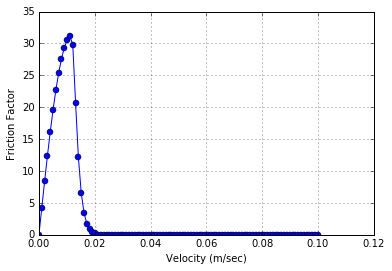

In [13]:
plt.plot(v_check,f_check,'o-')
plt.grid()
plt.xlabel('Velocity (m/sec)')
plt.ylabel('Friction Factor')

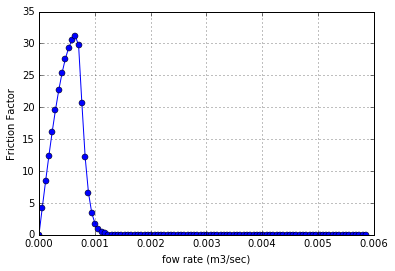

In [14]:
plt.plot(q_check,f_check,'o-')
plt.grid()
plt.xlabel('fow rate (m3/sec)')
plt.ylabel('Friction Factor')